In [ ]:
!pip install umap-learn

# Preparation
import sklearn
import sklearn.datasets
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.datasets import fetch_openml
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
import numpy as np
import umap
import scipy
import pickle
from scipy import sparse
from scipy.io import mmread
from pathlib import Path

#https://github.com/berenslab/rna-seq-tsne/blob/master/demo.ipynb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82813 sha256=d6463344db8ce44f6b5abdfc1b1844cd0425c45b0968703022ffee9a7a92d643
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55621 sha256=831c1e1b8e5427490e73c19b2af18fa07b8355088e7a3dcc80d25bdcd1b5cf32
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [ ]:
## The adult mouse cortex data set (Figure A9; Tasic et al., 2018) was downloaded in form of read counts from http://celltypes.brain-map.org/api/v2/well_known_file_download/694413985
## and http://celltypes.brain-map.org/api/v2/well_known_file_download/694413179 for the VISp and ALM cortical areas, respectively.
## Only exon counts were used here.
## The cluster labels and cluster colors were retrieved from http://celltypes.brain-map.org/rnaseq/mouse/v1-alm.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir("/content/gdrive/MyDrive/ne-spectrum-master/static")
import rnaseqTools

Mounted at /content/gdrive


## Data Loading

In [ ]:
# Load the Allen institute data. This takes a few minutes
#https://github.com/berenslab/rna-seq-tsne/blob/master/demo.ipynb
# This function is needed because using Pandas to load these files in one go
# can eat up a lot of RAM. So we are doing it in chunks, and converting each
# chunk to the sparse matrix format on the fly.
def sparseload(filenames):
    genes = []
    sparseblocks = []
    areas = []
    cells = []
    for chunk1,chunk2 in zip(pd.read_csv(filenames[0], chunksize=1000, index_col=0, na_filter=False),
                             pd.read_csv(filenames[1], chunksize=1000, index_col=0, na_filter=False)):
        if len(cells)==0:
            cells = np.concatenate((chunk1.columns, chunk2.columns))
            areas = [0]*chunk1.columns.size + [1]*chunk2.columns.size

        genes.extend(list(chunk1.index))
        sparseblock1 = sparse.csr_matrix(chunk1.values.astype(float))
        sparseblock2 = sparse.csr_matrix(chunk2.values.astype(float))
        sparseblock = sparse.hstack((sparseblock1,sparseblock2), format='csr')
        sparseblocks.append([sparseblock])
        print('.', end='', flush=True)
    print(' done')
    counts = sparse.bmat(sparseblocks)
    return (counts.T, np.array(genes), cells, np.array(areas))

filenames = ['/content/gdrive/MyDrive/BUSI/UMAP/mouse_sgcell-rna/mouse_VISp_2018-06-14_exon-matrix.csv',
             '/content/gdrive/MyDrive/BUSI/UMAP/mouse_sgcell-rna/mouse_ALM_2018-06-14_exon-matrix.csv']
counts, genes, cells, areas = sparseload(filenames)

genesDF = pd.read_csv('/content/gdrive/MyDrive/BUSI/UMAP/mouse_sgcell-rna/mouse_VISp_2018-06-14_genes-rows.csv')
ids     = genesDF['gene_entrez_id'].tolist()
symbols = genesDF['gene_symbol'].tolist()
id2symbol = dict(zip(ids, symbols))
genes = np.array([id2symbol[g] for g in genes])

clusterInfo = pd.read_csv('/content/gdrive/MyDrive/BUSI/UMAP/mouse_sgcell-rna/sample_heatmap_plot_data.csv')
goodCells  = clusterInfo['sample_name'].values
ids        = clusterInfo['cluster_id'].values
labels     = clusterInfo['cluster_label'].values
colors     = clusterInfo['cluster_color'].values

clusterNames  = np.array([labels[ids==i+1][0] for i in range(np.max(ids))])
clusterColors = np.array([colors[ids==i+1][0] for i in range(np.max(ids))])
clusters   = np.copy(ids) - 1

ind = np.array([np.where(cells==c)[0][0] for c in goodCells])
counts = counts[ind, :]

tasic2018 = {'counts': counts, 'genes': genes, 'clusters': clusters, 'areas': areas,
             'clusterColors': clusterColors, 'clusterNames': clusterNames}
counts = []

.............................................. done


In [ ]:
print('Number of cells:', tasic2018['counts'].shape[0])
print('Number of cells from ALM:', np.sum(tasic2018['areas']==0))
print('Number of cells from VISp:', np.sum(tasic2018['areas']==1))
print('Number of clusters:', np.unique(tasic2018['clusters']).size)
print('Number of genes:', tasic2018['counts'].shape[1])
print('Fraction of zeros in the data matrix: {:.2f}'.format(
    tasic2018['counts'].size/np.prod(tasic2018['counts'].shape)))

Number of cells: 23822
Number of cells from ALM: 15413
Number of cells from VISp: 10068
Number of clusters: 133
Number of genes: 45768
Fraction of zeros in the data matrix: 0.20


## Preprocessing

CPU times: user 31.4 s, sys: 13.1 s, total: 44.6 s
Wall time: 58.4 s


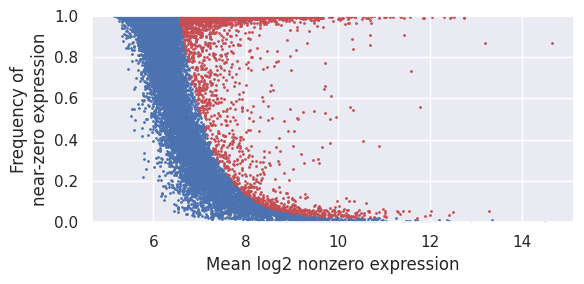

In [ ]:

%%time
#https://github.com/berenslab/rna-seq-tsne/blob/master/demo.ipynb
# Feature selection

def nearZeroRate(data, threshold=0):
    zeroRate = 1 - np.squeeze(np.array((data>threshold).mean(axis=0)))
    return zeroRate

def meanLogExpression(data, threshold=0, atleast=10):
    nonZeros = np.squeeze(np.array((data>threshold).sum(axis=0)))
    N = data.shape[0]
    A = data.multiply(data>threshold)
    A.data = np.log2(A.data)
    meanExpr = np.zeros(data.shape[1]) * np.nan
    detected = nonZeros >= atleast
    meanExpr[detected] = np.squeeze(np.array(A[:,detected].mean(axis=0))) / (nonZeros[detected]/N)
    return meanExpr

def featureSelection(meanLogExpression, nearZeroRate, yoffset=.02, decay=1.5, n=3000):
    low = 0; up=10
    nonan = ~np.isnan(meanLogExpression)
    xoffset = 5
    for step in range(100):
        selected = np.zeros_like(nearZeroRate).astype(bool)
        selected[nonan] = nearZeroRate[nonan] > np.exp(-decay*meanLogExpression[nonan] + xoffset) + yoffset
        if np.sum(selected) == n:
            break
        elif np.sum(selected) < n:
            up = xoffset
            xoffset = (xoffset + low)/2
        else:
            low = xoffset
            xoffset = (xoffset + up)/2
    return selected

x = meanLogExpression(tasic2018['counts'], threshold=32)  # Get mean log non-zero expression of each gene
y = nearZeroRate(tasic2018['counts'], threshold=32)       # Get near-zero frequency of each gene
selectedGenes = featureSelection(x, y, n=3000)            # Adjust the threshold to select 3000 genes

plt.figure(figsize=(6,3))
plt.scatter(x[~selectedGenes], y[~selectedGenes], s=1)
plt.scatter(x[selectedGenes],  y[selectedGenes], s=1, color='r')
plt.xlabel('Mean log2 nonzero expression')
plt.ylabel('Frequency of\nnear-zero expression')
plt.ylim([0,1])
plt.tight_layout()

In [ ]:
# %%time
#https://github.com/berenslab/rna-seq-tsne/blob/master/demo.ipynb
counts3k = tasic2018['counts'][:, selectedGenes]  # Feature selection

librarySizes = tasic2018['counts'].sum(axis=1)    # Compute library sizes
CPM = counts3k / librarySizes * 1e+6              # Library size normalisation

logCPM = np.log2(CPM + 1)                         # Log-transformation
logCPM_np = np.asarray(logCPM)                    # logCPM converted to np.ndarray

pca = PCA(n_components=50, svd_solver='full').fit(logCPM_np)   # PCA


flipSigns = np.sum(pca.components_, axis=1) < 0             # fix PC signs
X = pca.transform(logCPM_np)
X[:, flipSigns] *= -1

print('Shape of the resulting matrix:', X.shape, '\n')

Shape of the resulting matrix: (23822, 50) 




## Initial data exploration (PCA/MDS)

<ipython-input-26-9cd65a62cabe>:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=pca_df, x='PCA Dimension 1', y='PCA Dimension 2', palette='tab10', color=tasic2018['clusterColors'][tasic2018['clusters']])


<Axes: xlabel='PCA Dimension 1', ylabel='PCA Dimension 2'>

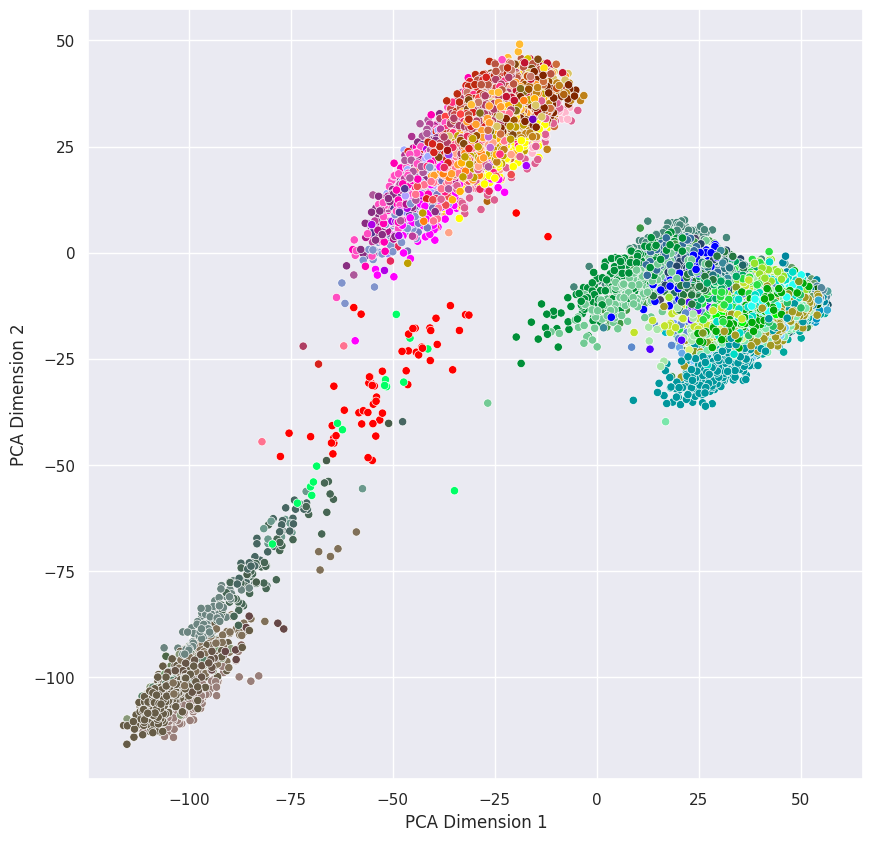

In [ ]:
# Principal component analysis
pca_df = pd.DataFrame({
    'PCA Dimension 1': X[:,0],
    'PCA Dimension 2': X[:,1]
})
plt.figure(figsize=(10,10))
sns.scatterplot(data=pca_df, x='PCA Dimension 1', y='PCA Dimension 2', palette='tab10', color=tasic2018['clusterColors'][tasic2018['clusters']])

CPU times: user 151 ms, sys: 200 ms, total: 351 ms
Wall time: 204 ms


<timed exec>:10: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.


<Axes: xlabel='PCA Dimension 1', ylabel='PCA Dimension 2'>

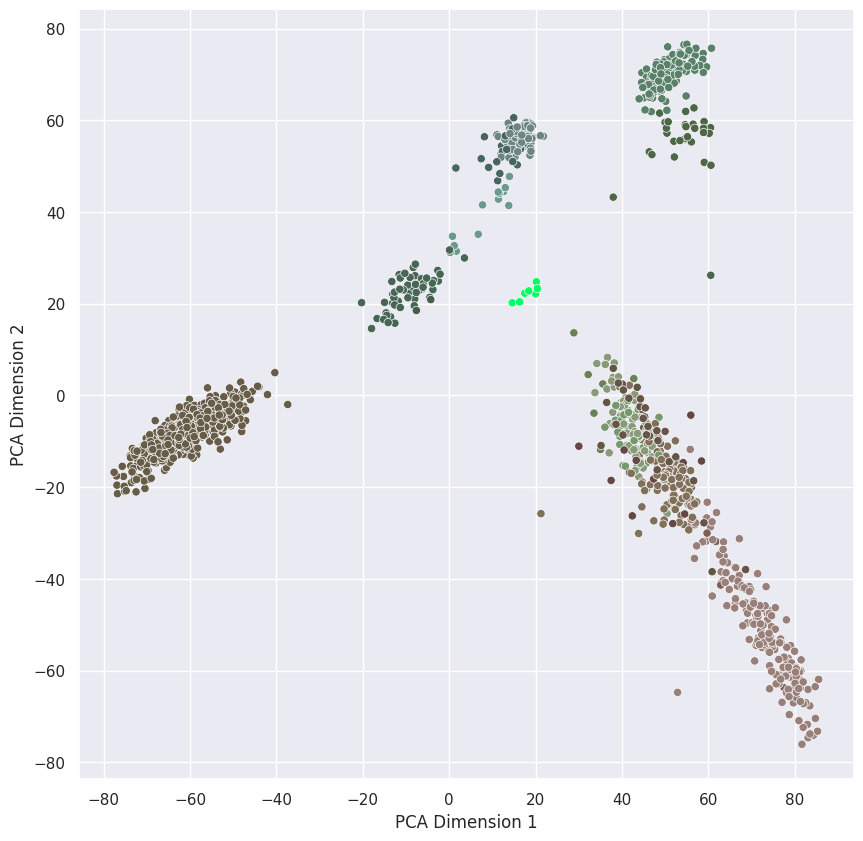

In [ ]:
%%time

# PCA on a subset identified in the previous figure
subset = (X[:,0] < -50) & (X[:,1] < -50)
Xsubset = PCA(n_components=2).fit_transform(X[subset,:])

pca_df = pd.DataFrame({
    'PCA Dimension 1': Xsubset[:,0],
    'PCA Dimension 2': Xsubset[:,1]
})
plt.figure(figsize=(10,10))
sns.scatterplot(data=pca_df, x='PCA Dimension 1', y='PCA Dimension 2', palette='tab10', color=tasic2018['clusterColors'][tasic2018['clusters'][subset]])

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


CPU times: user 1.56 s, sys: 853 ms, total: 2.41 s
Wall time: 4.3 s


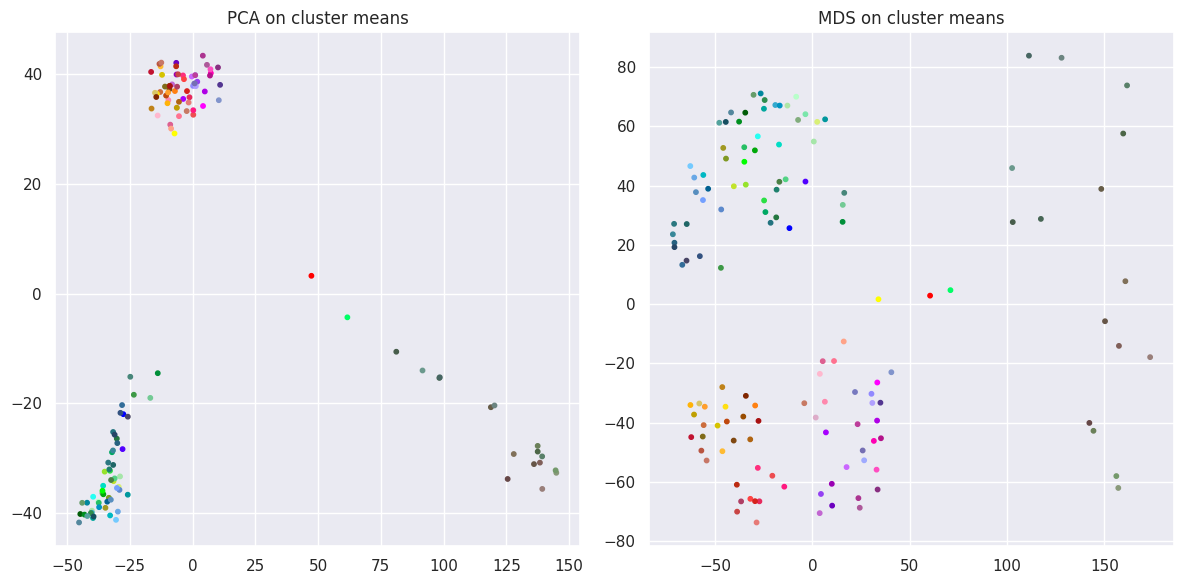

In [ ]:
%%time

# If clustering results are available, do PCA and/or MDS on the cluster means

C = np.unique(tasic2018['clusters']).size
clusterMeans = np.zeros((C, X.shape[1]))
for c in range(C):
    clusterMeans[c,:] = np.mean(X[tasic2018['clusters']==c,:], axis=0)

clusterMeansPCA = PCA(n_components=2, svd_solver='full').fit_transform(clusterMeans)
clusterMeansMDS = MDS(n_components=2, random_state=42).fit_transform(clusterMeans)

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(clusterMeansPCA[:,0], clusterMeansPCA[:,1], s=10, color=tasic2018['clusterColors'])
plt.title('PCA on cluster means')
plt.subplot(122)
plt.scatter(clusterMeansMDS[:,0], clusterMeansMDS[:,1], s=10, color=tasic2018['clusterColors'])
plt.title('MDS on cluster means')
plt.tight_layout()


## Standard Umap Visualization

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 4.77 µs


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
<ipython-input-8-f7b8ac893ea1>:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=umap_df, x='UMAP Dimension 1', y='UMAP Dimension 2', palette='tab10', color=tasic2018['clusterColors'][tasic2018['clusters']])


5340278784

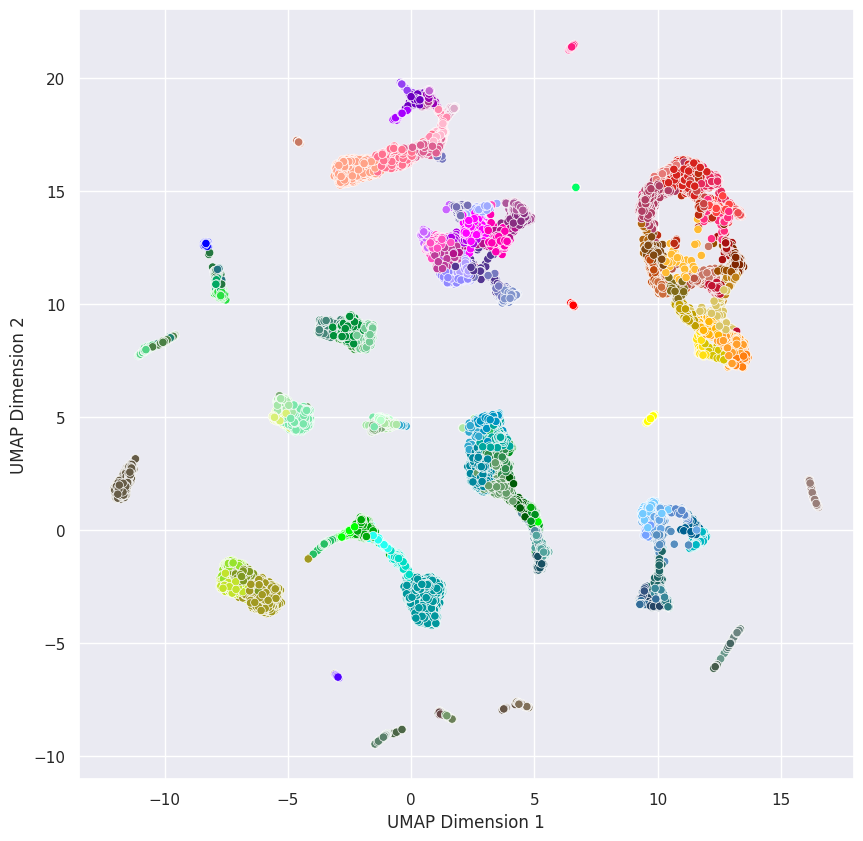

In [ ]:
! pip install psutil
import psutil

# The result will depend on the random seed (here, 42)
# Reduce dimensionality using UMAP
%time
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)
# rotation_matrix = np.array([[0, 0],
#                             [1, 0]])
# rotation_embedding = np.dot(embedding, rotation_matrix)
# Create a DataFrame for visualization
umap_df = pd.DataFrame({
    'UMAP Dimension 1': embedding[:, 0],
    'UMAP Dimension 2': embedding[:, 1]
})

# Plot the UMAP visualization using seaborn
plt.figure(figsize=(10,10))
# plt.gca().invert_xaxis()  # Invert the y-axis direction
sns.scatterplot(data=umap_df, x='UMAP Dimension 1', y='UMAP Dimension 2', palette='tab10', color=tasic2018['clusterColors'][tasic2018['clusters']])

def get_memory_usage():
    process = psutil.Process()
    return process.memory_info().rss

get_memory_usage()

In [ ]:
def get_memory_usage():
    process = psutil.Process()
    m = process.memory_info().rss
    mGB = m / (1024 ** 3)
    print (f"{mGB} GB")

get_memory_usage()

4.982349395751953 GB


## Standard Hessian LLE Visualization

<ipython-input-8-17e49f4f0d93>:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=hlle_df, x='HLLE Dimension 1', y='HLLE Dimension 2', palette='tab10', color=tasic2018['clusterColors'][tasic2018['clusters']])


<Axes: xlabel='HLLE Dimension 1', ylabel='HLLE Dimension 2'>

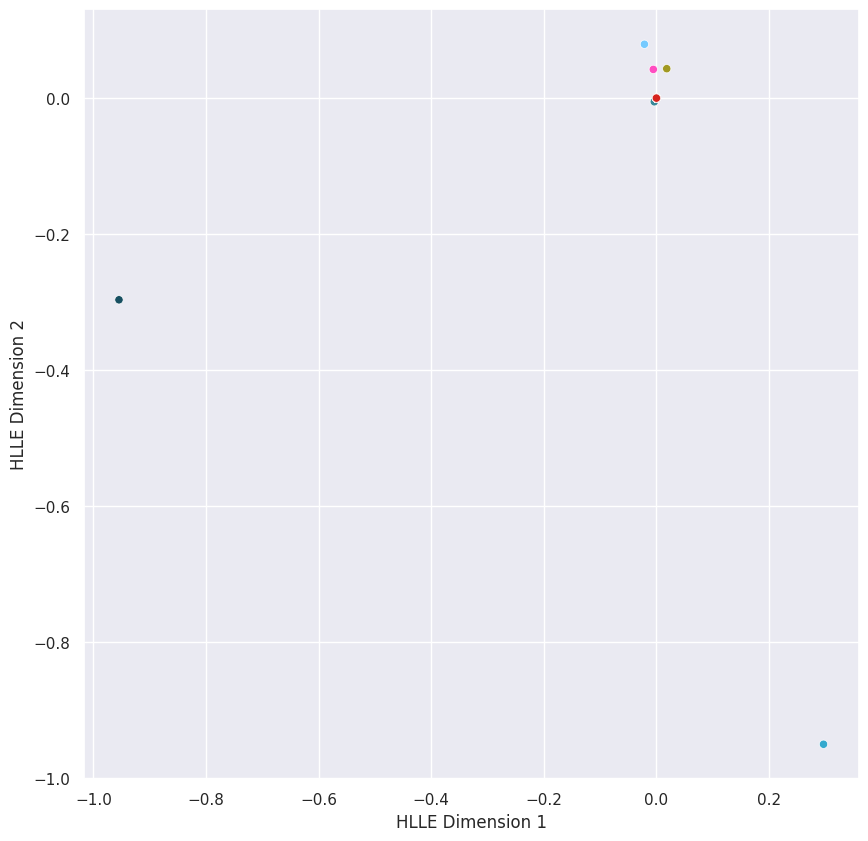

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

# Reduce dimensionality using Hessian LLE
hlle = LocallyLinearEmbedding(n_components=5, n_neighbors=30, random_state=None, method = "hessian", eigen_solver='dense')
embedding = hlle.fit_transform(X)

# Create a DataFrame for visualization
hlle_df = pd.DataFrame({
    'HLLE Dimension 1': embedding[:, 0],
    'HLLE Dimension 2': embedding[:, 1]
})

# Plot the LLE visualization using seaborn
plt.figure(figsize=(10,10))
sns.scatterplot(data=hlle_df, x='HLLE Dimension 1', y='HLLE Dimension 2', palette='tab10', color=tasic2018['clusterColors'][tasic2018['clusters']])

In [ ]:
! pip install psutil
import psutil

def get_memory_usage():
    process = psutil.Process()
    m = process.memory_info().rss
    mGB = m / (1024 ** 3)
    print (f"{mGB} GB")

get_memory_usage()

4.840641021728516 GB
